* PAPER - Encoder-Decoder with Atrous Separable Convolution for Semantic Image Segmentation - [PDF](https://arxiv.org/pdf/1802.02611.pdf)
* PAPER - Rethinking Atrous Convolution for Semantic Image Segmentation - [PDF](https://arxiv.org/pdf/1706.05587.pdf)
* PAPER - DeepLab: Semantic Image Segmentation with Deep Convolutional Nets, Atrous Convolution, and Fully Connected CRFs - [PDF](https://arxiv.org/pdf/1606.00915.pdf)

![](https://github.com/lattice-ai/DeepLabV3-Plus/raw/master/assets/deeplabv3_plus_diagram.png)
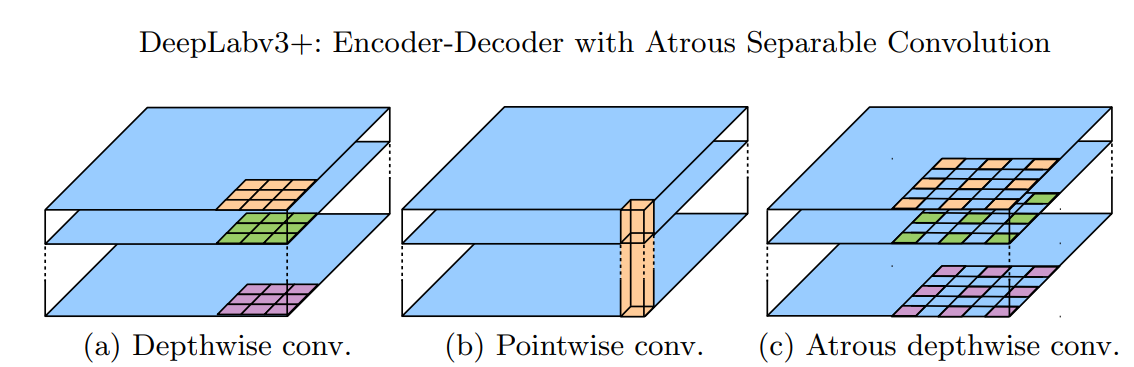

# 준비

## 라이브러리 호출

In [1]:
import os
import cv2
import numpy as np
from glob import glob
from scipy.io import loadmat
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

## 데이터

In [9]:
IMAGE_SIZE = 512
BATCH_SIZE = 1
NUM_CLASSES = 20
DATA_DIR = "D:/Dataset/dataset/Sementic_Segmentation/instance-level_human_parsing/Training/"
NUM_TRAIN_IMAGES = 1000
NUM_VAL_IMAGES = 50

train_images = sorted(glob(os.path.join(DATA_DIR, "Images/*")))[:NUM_TRAIN_IMAGES]
train_masks = sorted(glob(os.path.join(DATA_DIR, "Category_ids/*")))[:NUM_TRAIN_IMAGES]
val_images = sorted(glob(os.path.join(DATA_DIR, "Images/*")))[NUM_TRAIN_IMAGES : NUM_VAL_IMAGES + NUM_TRAIN_IMAGES]
val_masks = sorted(glob(os.path.join(DATA_DIR, "Category_ids/*")))[NUM_TRAIN_IMAGES : NUM_VAL_IMAGES + NUM_TRAIN_IMAGES]

## 데이터 셋

In [10]:
def read_image(image_path, mask=False):
    image = tf.io.read_file(image_path)
    if mask:
        image = tf.image.decode_png(image, channels=1)
        image.set_shape([None, None, 1])
        image = tf.image.resize(images=image, size=[IMAGE_SIZE, IMAGE_SIZE])
    else:
        image = tf.image.decode_png(image, channels=3)
        image.set_shape([None, None, 3])
        image = tf.image.resize(images=image, size=[IMAGE_SIZE, IMAGE_SIZE])
        image = image / 127.5 - 1
    return image

def load_data(image_list, mask_list):
    image = read_image(image_list)
    mask = read_image(mask_list, mask=True)
    return image, mask

def data_generator(image_list, mask_list):
    dataset = tf.data.Dataset.from_tensor_slices((image_list, mask_list))
    dataset = dataset.map(load_data, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
    return dataset

In [11]:
train_dataset = data_generator(train_images, train_masks)
val_dataset = data_generator(val_images, val_masks)

print("Train Dataset:", train_dataset)
print("Val Dataset:", val_dataset)

Train Dataset: <BatchDataset element_spec=(TensorSpec(shape=(1, 512, 512, 3), dtype=tf.float32, name=None), TensorSpec(shape=(1, 512, 512, 1), dtype=tf.float32, name=None))>
Val Dataset: <BatchDataset element_spec=(TensorSpec(shape=(1, 512, 512, 3), dtype=tf.float32, name=None), TensorSpec(shape=(1, 512, 512, 1), dtype=tf.float32, name=None))>


In [12]:
def ASPP(inputs):
    """shape"""
    shape = inputs.shape
    
    """ASPP(Atrous Spatial Pyramid Pooling)"""
    # Image Pooling
    y_pool = tf.keras.layers.AveragePooling2D(pool_size=(shape[1], shape[2]))(inputs)
    y_pool = tf.keras.layers.Conv2D(filters=256, kernel_size=1, padding="same", use_bias=False)(y_pool)
    y_pool = tf.keras.layers.BatchNormalization()(y_pool)
    y_pool = tf.keras.layers.Activation("relu")(y_pool)
    y_pool = tf.keras.layers.UpSampling2D( (shape[1], shape[2]), interpolation="bilinear")(y_pool)
    # 1X1 Conv
    y_1 = tf.keras.layers.Conv2D(filters=256, kernel_size=1, padding="same", use_bias=False)(inputs)
    y_1 = tf.keras.layers.BatchNormalization()(y_1)
    y_1 = tf.keras.layers.Activation("relu")(y_1)
    # 3X3 Conv dilation_rate:6
    y_6 = tf.keras.layers.Conv2D(filters=256, kernel_size=3, dilation_rate=6, padding="same", use_bias=False)(inputs)
    y_6 = tf.keras.layers.BatchNormalization()(y_6)
    y_6 = tf.keras.layers.Activation("relu")(y_6)
    # 3X3 Conv dilation_rate:12
    y_12 = tf.keras.layers.Conv2D(filters=256, kernel_size=3, dilation_rate=12, padding="same", use_bias=False)(inputs)
    y_12 = tf.keras.layers.BatchNormalization()(y_12)
    y_12 = tf.keras.layers.Activation("relu")(y_12)
    # 3X3 Conv dilation_rate:18
    y_18 = tf.keras.layers.Conv2D(filters=256, kernel_size=3, dilation_rate=18, padding="same", use_bias=False)(inputs)
    y_18 = tf.keras.layers.BatchNormalization()(y_18)
    y_18 = tf.keras.layers.Activation("relu")(y_18)
    
    # Concat
    y = tf.keras.layers.Concatenate()([y_pool, y_1, y_6, y_12, y_18])
    
    # 1X1 Conv
    y = tf.keras.layers.Conv2D(filters=256, kernel_size=1, dilation_rate=1, padding="same", use_bias=False)(y)
    y = tf.keras.layers.BatchNormalization()(y)
    y = tf.keras.layers.Activation("relu")(y)
    
    return y
    
def Deeplabv3plus(shape):
    """ inputs"""
    inputs = keras.layers.Input(shape)
    
    """ Pre-trained ResNet50 """
    base_model = tf.keras.applications.ResNet50(weights='imagenet', include_top=False, input_tensor=inputs)
    
    """ Pre-trained ResNet50 Output """
    image_features = base_model.get_layer("conv4_block6_out").output
    x_a = ASPP(image_features)
    x_a = tf.keras.layers.UpSampling2D( (4,4), interpolation="bilinear")(x_a)
    
    """ Get low_level feature """
    x_b = base_model.get_layer("conv2_block2_out").output
    x_b = tf.keras.layers.Conv2D(filters=48, kernel_size=1, padding="same", use_bias=False)(x_b)
    x_b = tf.keras.layers.BatchNormalization()(x_b)
    x_b = tf.keras.layers.Activation("relu")(x_b)
    
    # Concatenate
    x = tf.keras.layers.Concatenate()([x_a, x_b])
    
    # 3X3 Conv
    x = tf.keras.layers.Conv2D(filters=256, kernel_size=3, padding="same", use_bias=False)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation("relu")(x)
    
    # 3X3 Conv
    x = tf.keras.layers.Conv2D(filters=256, kernel_size=3, padding="same", use_bias=False)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation("relu")(x)
    
    # Upsampleing
    x = tf.keras.layers.UpSampling2D( (4,4), interpolation="bilinear")(x)
    
    """ Outputs """
    x = tf.keras.layers.Conv2D(NUM_CLASSES, (1,1), name="output_layer")(x)
    
    """ Model """
    model = tf.keras.models.Model(inputs=inputs, outputs=x)
    return model

In [13]:
input_shape = (IMAGE_SIZE,IMAGE_SIZE,3)
model = Deeplabv3plus(input_shape)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 518, 518, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 256, 256, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

 conv2_block2_add (Add)         (None, 128, 128, 25  0           ['conv2_block1_out[0][0]',       
                                6)                                'conv2_block2_3_bn[0][0]']      
                                                                                                  
 conv2_block2_out (Activation)  (None, 128, 128, 25  0           ['conv2_block2_add[0][0]']       
                                6)                                                                
                                                                                                  
 conv2_block3_1_conv (Conv2D)   (None, 128, 128, 64  16448       ['conv2_block2_out[0][0]']       
                                )                                                                 
                                                                                                  
 conv2_block3_1_bn (BatchNormal  (None, 128, 128, 64  256        ['conv2_block3_1_conv[0][0]']    
 ization) 

 conv3_block2_3_conv (Conv2D)   (None, 64, 64, 512)  66048       ['conv3_block2_2_relu[0][0]']    
                                                                                                  
 conv3_block2_3_bn (BatchNormal  (None, 64, 64, 512)  2048       ['conv3_block2_3_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block2_add (Add)         (None, 64, 64, 512)  0           ['conv3_block1_out[0][0]',       
                                                                  'conv3_block2_3_bn[0][0]']      
                                                                                                  
 conv3_block2_out (Activation)  (None, 64, 64, 512)  0           ['conv3_block2_add[0][0]']       
                                                                                                  
 conv3_blo

                                                                                                  
 conv4_block1_0_bn (BatchNormal  (None, 32, 32, 1024  4096       ['conv4_block1_0_conv[0][0]']    
 ization)                       )                                                                 
                                                                                                  
 conv4_block1_3_bn (BatchNormal  (None, 32, 32, 1024  4096       ['conv4_block1_3_conv[0][0]']    
 ization)                       )                                                                 
                                                                                                  
 conv4_block1_add (Add)         (None, 32, 32, 1024  0           ['conv4_block1_0_bn[0][0]',      
                                )                                 'conv4_block1_3_bn[0][0]']      
                                                                                                  
 conv4_blo

 n)                                                                                               
                                                                                                  
 conv4_block4_3_conv (Conv2D)   (None, 32, 32, 1024  263168      ['conv4_block4_2_relu[0][0]']    
                                )                                                                 
                                                                                                  
 conv4_block4_3_bn (BatchNormal  (None, 32, 32, 1024  4096       ['conv4_block4_3_conv[0][0]']    
 ization)                       )                                                                 
                                                                                                  
 conv4_block4_add (Add)         (None, 32, 32, 1024  0           ['conv4_block3_out[0][0]',       
                                )                                 'conv4_block4_3_bn[0][0]']      
          

                                                                                                  
 conv2d_13 (Conv2D)             (None, 32, 32, 256)  2359296     ['conv4_block6_out[0][0]']       
                                                                                                  
 activation_9 (Activation)      (None, 1, 1, 256)    0           ['batch_normalization_9[0][0]']  
                                                                                                  
 batch_normalization_10 (BatchN  (None, 32, 32, 256)  1024       ['conv2d_10[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_11 (BatchN  (None, 32, 32, 256)  1024       ['conv2d_11[0][0]']              
 ormalization)                                                                                    
          

In [ ]:
loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss=loss,
    metrics=["accuracy"],
)

history = model.fit(train_dataset, validation_data=val_dataset, epochs=25)

plt.plot(history.history["loss"])
plt.title("Training Loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.show()

plt.plot(history.history["accuracy"])
plt.title("Training Accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.show()

plt.plot(history.history["val_loss"])
plt.title("Validation Loss")
plt.ylabel("val_loss")
plt.xlabel("epoch")
plt.show()

plt.plot(history.history["val_accuracy"])
plt.title("Validation Accuracy")
plt.ylabel("val_accuracy")
plt.xlabel("epoch")
plt.show()

Epoch 1/25
1000/1000 [==============================] - 105s 99ms/step - loss: 1.2608 - accuracy: 0.6164 - val_loss: nan - val_accuracy: 0.5947
Epoch 2/25
 472/1000 [=============>................] - ETA: 51s - loss: 1.0918 - accuracy: 0.6661